# Cercospora Sensor Comparisons - 2022

A.J. Brown  
ansley.brown@colostate.edu  
CSU Agriculture Water Quality Program  
23 September 2022

In [1]:
# To convert to html and hide code, run the following console command in the same directory as the ipynb:
# jupyter nbconvert YourNotebook.ipynb --no-input --to html
# DO NOT use the export in Jupyter Lab

## Table of contents
1. [Executive Summary](#legend)
2. [Sensor Locations and IDs](#map)
3. [Interactive Graphics](#graphics)
    1. [Temperature](#temp)
    2. [Humidity](#rh)
4. [Table of Raw Data](#data)

## Executive Summary <a name="legend"></a>
In 2022, the Colorado State University (CSU) Agriculture Water Quality Program (AWQP), in collaboration with Wester Sugar (WS), prototyped and deployed four temperature (T) and relative humidity (RH) sensors to determine daily infection values (DIVs) for CLS with the help of University of Nebraska-Lincoln collaborators. Furthermore, CSU AWQP prototyped and developed 14 sugar beet pile sensors to monitor T continuously that are still deployed to date (19 Dec. 2022). This report details the methods and performance of developed sensors and makes recommendations for further research.

CSU sensors are in general agreeance with the WS thermometers and sensors within 2°F, which would suggest they could be a reasonable substitute.  This provides great advantage to managers, however, as the CSU sensors provide data every 2 hours as opposed to once a day.  Additionally, data can be acquired from a mobile device or computer using the same data portal used for the CLS sensors (for security and convenience) as opposed to walking on top of each sugar beet pile and extracting thermometers manually.

Using the cloud capabilities of the CSU sensors, sugar beet pile temperatures were able to be monitored live via the cloud platform, Ubidots, where a custom data portal was created for WS.

Moving forward, CSU intends to continue and expand collaborations with WSC and UNL to provide growers with the information needed most for better pile temperature management.

In [2]:
# Import libraries
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from itables import show
from statsmodels.tools.eval_measures import rmse

In [3]:
# Import data
df = pd.read_csv(r"C:\Users\ansleybr\Documents\GitHub\pile-temp-sensor-comparison\Data\pt_comparison_data.csv", na_values=['-'])

In [4]:
# Data Cleaning 
## clean whitespace from column names
df.columns = df.columns.str.replace(' ', '')
dfx = df.copy()
## Make column names uppercase
df.columns = df.columns.str.upper()

In [5]:
#converting to type numeric as possible <- only run this block once, else you will encounter errors
df = df.apply(pd.to_numeric, errors='ignore')

In [6]:
## Make 'TIME' into a datetime format
df['DATE'] = pd.to_datetime(df['DATE'].astype(str))

In [12]:
#create CSU and WS dataframes and merge by nearest timestamp and location for comparison
csu_df = df[df['OWNER'] == 'CSU'].sort_values(by='DATE').dropna(how='any')
ws_df = df[df['OWNER'] == 'Western Sugar'].sort_values(by='DATE').dropna(how='any')
merged_df = pd.merge(csu_df, ws_df,
                          on=['DATE','GROUP','PILE-TYPE','LOCATION'],
                          suffixes=('_CSU', '_WS'))

In [21]:
df.OWNER

0      Western Sugar
1                CSU
2      Western Sugar
3                CSU
4      Western Sugar
           ...      
114    Western Sugar
115              CSU
116    Western Sugar
117              CSU
118              NaN
Name: OWNER, Length: 119, dtype: object

## Interactive Graphics (Hover over graphs with mouse to get additional info) <a name="graphics"></a>

### Temperature Comparison (Farenheit) <a name="temp"></a>

#### 1:1 Plot Stratified by Comparison Group (i.e., pairs of CSU and WS sensors placed next to each other)

In [7]:
fig_temp = px.scatter(
           merged_df, 
           x="TEMP_CSU", 
           y="TEMP_WS",
           color = 'GROUP',
           facet_col='GROUP',
           facet_col_wrap = 4,
           trendline='ols',
           trendline_color_override='black',
           hover_data=['DATE'],
           template='simple_white',
           opacity=0.5
)
fig_temp.update_yaxes(
         scaleanchor = "x",
         scaleratio = 1,
)
fig_temp.show()

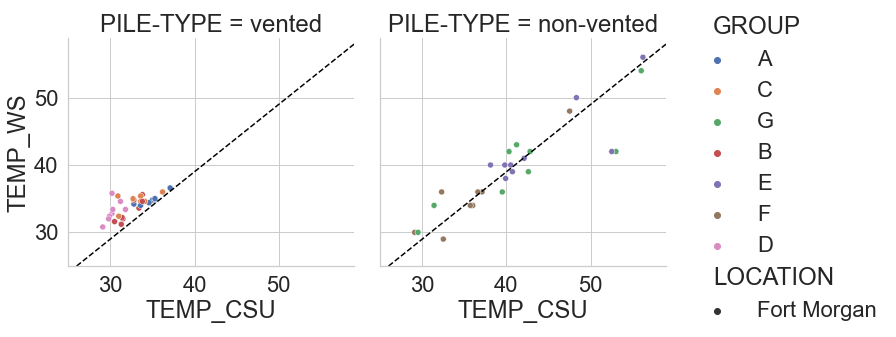

In [14]:
# Uncomment for fixed 1:1 plots
sns.set(font_scale=2) # make font bigger
sns.set_style("whitegrid")
fixed_temp_fig = sns.relplot(data=merged_df,
                            x='TEMP_CSU',
                            y='TEMP_WS',
                            col='PILE-TYPE',
                            #col_wrap = 2,
                            hue='GROUP',
                            style='LOCATION'
                            )
                            #line_kws={'color':'black'},
                            #scatter_kws={'alpha':0.5},
                            #ci=95)
fixed_temp_fig.map_dataframe(lambda data, **kws: plt.axline((1, 0), slope=1, color='black', linestyle='--')) # applies the fxn: y = 1*x - 0
fixed_temp_fig.set(xlim=(25,None), ylim=(25,None))
#fixed_temp_fig.add_legend()
plt.savefig('group_comparisons.png')
plt.show()

In [15]:
results_temp = px.get_trendline_results(fig_temp)
#print(results)

In [16]:
def rmse_vals(results, unit):
    rmseList = []
    for i in range(len(results)):
        rmse = (sum(np.square(results.iloc[i]['px_fit_results'].resid))/len(results.iloc[i]['px_fit_results'].resid))**(0.5)
        loc_names = results['GROUP'][i]
        rmseList.append(rmse)
        print('The Root Mean Squared Error (RMSE) for {} is +/- {:.2f} {}'.format(loc_names, rmse, unit))
    print('The mean RMSE over all groups is +/- {:.2f} {}'.format(np.average(rmseList), unit))

In [17]:
rmse_vals(results_temp, unit='Farenheit')

The Root Mean Squared Error (RMSE) for A is +/- 0.30 Farenheit
The Root Mean Squared Error (RMSE) for C is +/- 0.85 Farenheit
The Root Mean Squared Error (RMSE) for G is +/- 3.06 Farenheit
The Root Mean Squared Error (RMSE) for B is +/- 0.65 Farenheit
The Root Mean Squared Error (RMSE) for E is +/- 3.18 Farenheit
The Root Mean Squared Error (RMSE) for F is +/- 1.98 Farenheit
The Root Mean Squared Error (RMSE) for D is +/- 1.19 Farenheit
The mean RMSE over all groups is +/- 1.60 Farenheit


#### Timeseries Plots Stratified by Location

In [24]:
fig_temp_time = px.line(
    df.sort_values(by='DATE').dropna(), 
    x="DATE", 
    y="TEMP",
    color = 'OWNER',
    facet_col="GROUP",
    template='simple_white'
)
fig_temp_time.update_traces(opacity=0.7)
fig_temp_time.show()

## Table of Raw Data <a name="data"></a>

In [36]:
show(merged_df)